# An example of a standard adaptive learning approach for handling concept drift 

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from river.tree import HoeffdingTreeClassifier
from streamselect.concept_representations import ErrorRateRepresentation
from streamselect.states import State
from streamselect.repository import Repository


First lets construct a dataset with concept drift.

Let us implement a simple 1d input x, with a threshold. Above the threshold y = 1, and below y = 0.
To represent abrupt concept drift, this threshold starts at 0.0 and changes to 1.0 halfway through the stream.

Text(0, 0.5, 'x')

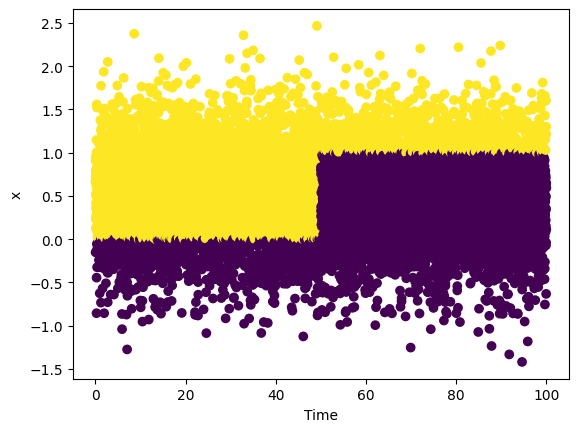

In [2]:
rng = np.random.default_rng(seed=1)
X = rng.normal(0.5, 0.5, 10000)
T = np.linspace(0, 100, 10000)
Y = X > (0.25 * np.floor(T/50)*4)
plt.scatter(T, X, c=Y)
plt.xlabel("Time")
plt.ylabel("x")

Next, we implement a simple naive bayes classifier to attempt to learn the threshold.
Since the threshold changes, our learned threshold will become out-of-date- halfway through the stream.
This leads to accuracy falling substantially.

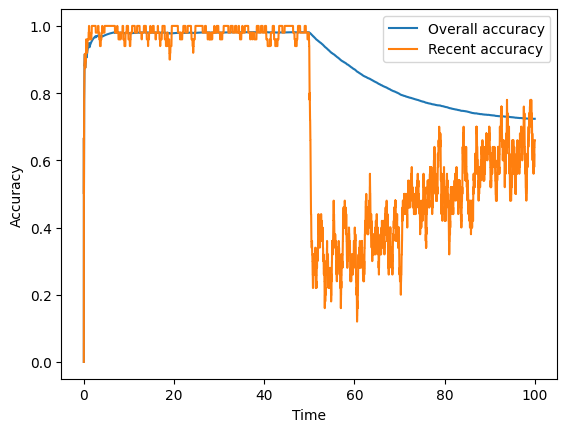

In [4]:
from river import naive_bayes
from river import stream
from river.metrics import Accuracy
from river.utils import Rolling

model = naive_bayes.GaussianNB()
acc = Accuracy()
rolling_acc = Rolling(Accuracy(), 50)
accuracy_over_time = []
rolling_accuracy_over_time = []
for x, y in stream.iter_array(X.reshape(-1, 1), Y):
    p = model.predict_one(x)
    _ = model.learn_one(x, y)
    acc.update(y, p)
    rolling_acc.update(y, p)
    accuracy_over_time.append(acc.get())
    rolling_accuracy_over_time.append(rolling_acc.get())

acc.get()

plt.plot(T, accuracy_over_time, label="Overall accuracy")
plt.plot(T, rolling_accuracy_over_time, label="Recent accuracy")
plt.xlabel("Time")
plt.ylabel("Accuracy")
plt.legend()

## Adaptive Learning

In the above example, our classifier encountered degraded accuracy because the *distribution* of data *changed* over time. This is known as concept drift. The basic idea of adaptive learning is to detect when concept drift has occured, and adapt the classifier to the new distribution. 

- 1) To detect concept drift, the overall idea is to *represent* the current concept, or distribution, on which our classifier is trained. If we also represent the distribution which recent data is drawn from, we could compare the two representations to get an idea of how well our classifier will handle incoming data. In other words, we can monitor the similarity between the two representations for concept drift.

- 2) When we detect concept drift, we need to adapt our classifier. In this case, we observe that old data before the concept drift is invalid, so we can discard it and build a new classifier.


### Representations

Let's first handle the representations. To do this, we define a simple data struction combining a classifier with some representation. We call this a *state*.
A standard representation is to use the error rate of the classifier. This representation is built on the idea that a classifier has learned to represent a given distribution of data, so it's error rate can be used to identify whether other data is behaving similarly or differently to the distribution it was trained on.

Lets first visualize the similarity between the current state and recent data.

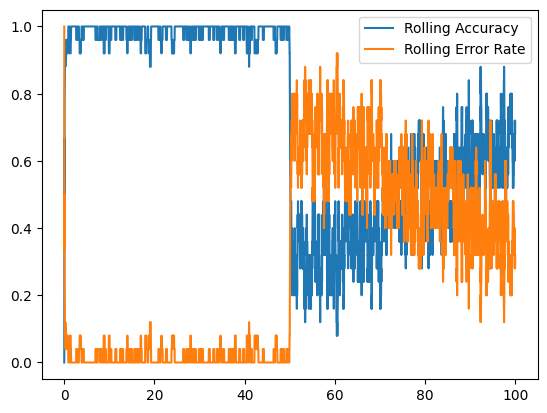

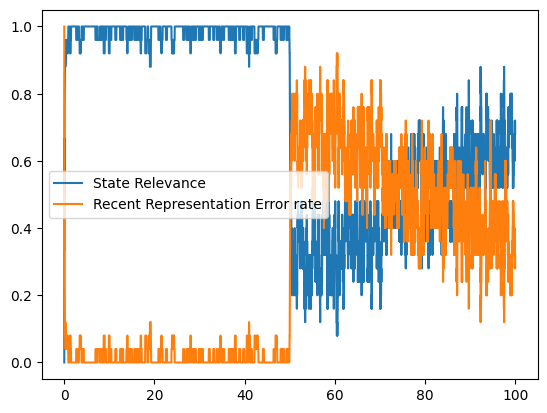

In [7]:

from streamselect.repository import AbsoluteValueComparer
from streamselect.utils import Observation

# Set some parameters for out system
# Window size is the number of observations we use to take a new reading
# In this case, we calculate error rate over the previous 25 observations
window_size = 25
# Update_period is the gap between updating each representation.
# In this case, we update each representation at every observation.
update_period = 1

# Setup a repository to keep track of states
# We need to tell the repository how to create new classifiers and representations when we add a new state.
classifier_constructor = naive_bayes.GaussianNB
representation_constructor = lambda state_id: ErrorRateRepresentation(window_size=window_size, concept_id=state_id, mode="concept", update_period=update_period)
state_repository = Repository(
    classifier_constructor=classifier_constructor,
    representation_constructor=representation_constructor
)


active_state = state_repository.add_next_state()

# Finally, we need a comparer to calculate the similarity
# between the current state representation and a representation
# of recent data
sim = AbsoluteValueComparer()

def get_state_relevance(sim, state: State, recent_representation):
    """ The relevance of a state to recent data is given by
    the similarity between representations. """
    return sim.get_similarity(state.get_self_representation(), recent_representation)

recent_representation = ErrorRateRepresentation(window_size=window_size, concept_id=active_state.state_id, update_period=update_period)
state_relevance = []
recent_representation_value = []
accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

# In this case, we leave the representation of the state as default, he default error rate representation has a value of 0.0.
# Implicitly, what this standard approach does is assume the current state
# perfectly represents the current concept.
# A drift is then detected when we have evidence against this hypothesis.
active_state.deactivate_train_representation()

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    # Most objects encapsulate the data related to an observation in an Observation object
    # This allows us to easily pass data between components without copying memory.
    observation = Observation(x=x, y=y, seen_at=t, active_state_id=active_state.state_id)
    p = active_state.predict_one(observation)
    # predictions are automatically tracked by the observation
    assert p == observation.predictions[active_state.state_id]

    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())

    # Now we can update the state, and our recent representation
    # using the observation.
    # Note: States only train their classifier when passed an observation 
    # with an active_state_id matching the state_id. The prevents a classifier
    # from acidentally being trained on a different concept. We can force this
    # behaviour with force_train_classifier if needed.
    _ = active_state.learn_one(observation)
    # Update the representation of recent data. We don't need to pass the prediction
    # as it is tracked in the observation, we just need to ensure predict is called
    # on the observation prior.
    recent_representation.learn_one(observation)

    # The relevance of the current state represents the similarity between it's
    # representation and recent data.
    curr_state_relevance = get_state_relevance(sim, active_state, recent_representation)

    # Saving results for plotting
    state_relevance.append(curr_state_relevance)
    recent_representation_value.append(recent_representation.meta_feature_values[0])

plt.plot(T, accuracy, label="Rolling Accuracy")
plt.plot(T, error_rate, label="Rolling Error Rate")
plt.legend()
plt.show()

plt.plot(T, state_relevance, label="State Relevance")
plt.plot(T, recent_representation_value, label="Recent Representation Error rate")
plt.legend()

    



In this case, we did not train the state representation, instead compared to an implied representation of 0.0 error rate. This means that the relevance of the current state is directly the inverse of the error rate of the current state. This makes intuitive sense, if our classifier starts performing worse, it has become less relevant. This idea is formalized in the 'Probably Approximately Correct' (PAC) framework, which describes how the accuracy of a classifier should increase if it trains on more data from a stationary distribution.

It usually makes more sense to train the state representation, giving us a relevance similarity between recent data and what data looked like in stable conditions. We can test this by simply allowing the state representation to train.

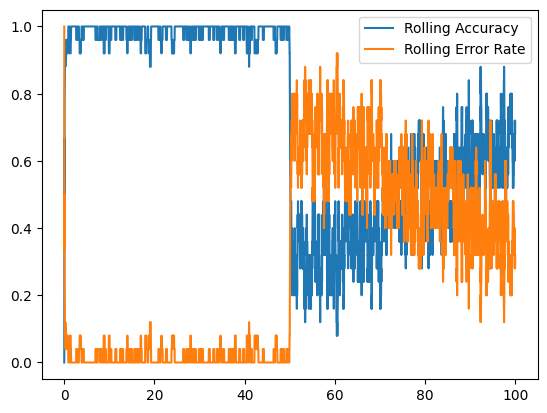

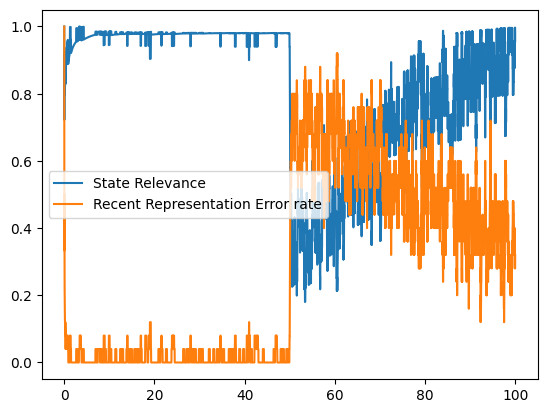

In [9]:
# Set some parameters for out system
window_size = 25
update_period = 1

# Setup a repository to keep track of states
# We need to tell the repository how to create new classifiers and representations when we add a new state.
classifier_constructor = naive_bayes.GaussianNB
representation_constructor = lambda state_id: ErrorRateRepresentation(window_size=window_size, concept_id=state_id, mode="concept", update_period=update_period)
state_repository = Repository(
    classifier_constructor=classifier_constructor,
    representation_constructor=representation_constructor
)


active_state = state_repository.add_next_state()

# Finally, we need a comparer to calculate the similarity
# between the current state representation and a representation
# of recent data
sim = AbsoluteValueComparer()

def get_state_relevance(sim, state: State, recent_representation):
    """ The relevance of a state to recent data is given by
    the similarity between representations. """
    return sim.get_similarity(state.get_self_representation(), recent_representation)

recent_representation = ErrorRateRepresentation(window_size=window_size, concept_id=active_state.state_id, update_period=update_period)
state_relevance = []
recent_representation_value = []
accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    # Most objects encapsulate the data related to an observation in an Observation object
    # This allows us to easily pass data between components without copying memory.
    observation = Observation(x=x, y=y, seen_at=t, active_state_id=active_state.state_id)
    p = active_state.predict_one(observation)
    # predictions are automatically tracked by the observation
    assert p == observation.predictions[active_state.state_id]

    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())

    # Now we can update the state, and our recent representation
    # using the observation.
    # Note: States only train their classifier when passed an observation 
    # with an active_state_id matching the state_id. The prevents a classifier
    # from acidentally being trained on a different concept. We can force this
    # behaviour with force_train_classifier if needed.
    _ = active_state.learn_one(observation)
    # Update the representation of recent data. We don't need to pass the prediction
    # as it is tracked in the observation, we just need to ensure predict is called
    # on the observation prior.
    recent_representation.learn_one(observation)

    # The relevance of the current state represents the similarity between it's
    # representation and recent data.
    curr_state_relevance = get_state_relevance(sim, active_state, recent_representation)

    # Saving results for plotting
    state_relevance.append(curr_state_relevance)
    recent_representation_value.append(recent_representation.meta_feature_values[0])

plt.plot(T, accuracy, label="Rolling Accuracy")
plt.plot(T, error_rate, label="Rolling Error Rate")
plt.legend()
plt.show()

plt.plot(T, state_relevance, label="State Relevance")
plt.plot(T, recent_representation_value, label="Recent Representation Error rate")
plt.legend()

In this case, our relevance reflects accuracy, but is not directly equal to accuracy.


We should detect this drop in relevance as concept drift.

(Note: Many approaches take a shortcut of directly monitoring classifier error rate. This directly corresponds to relevance when calculated as in this example, however in this library we provide a variety of more powerful relevance measures which are able to more accurately detect change in distribution. The approach we describe here can be directly ported to these other representations.)

In the code below, we use the ADWIN drift detector to detect a change in the relevance of the current classifier, which is plotted as a red line.

Overall average accuracy was: 0.7235481416977827


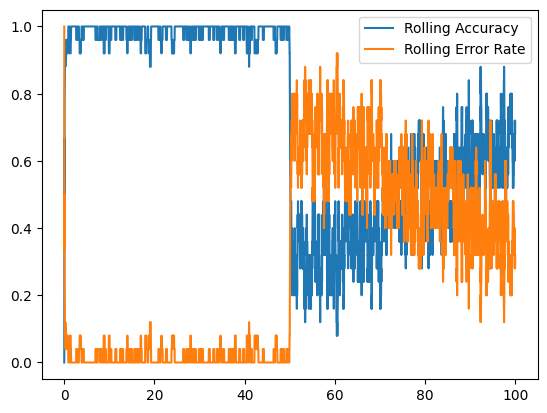

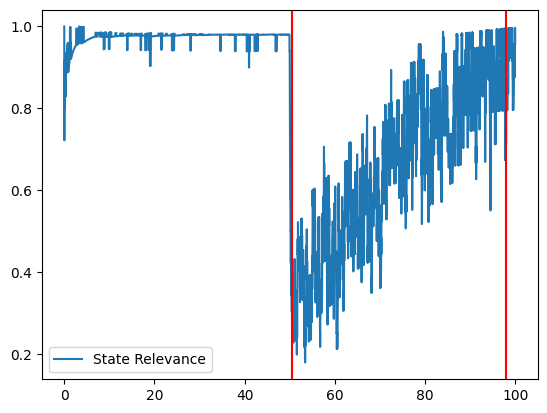

In [11]:
from river.drift import ADWIN

# Set some parameters for out system
window_size = 25
update_period = 1

# Setup a repository to keep track of states
# We need to tell the repository how to create new classifiers and representations when we add a new state.
classifier_constructor = naive_bayes.GaussianNB
representation_constructor = lambda state_id: ErrorRateRepresentation(window_size=window_size, concept_id=state_id, mode="concept", update_period=update_period)
state_repository = Repository(
    classifier_constructor=classifier_constructor,
    representation_constructor=representation_constructor
)


active_state = state_repository.add_next_state()

# Finally, we need a comparer to calculate the similarity
# between the current state representation and a representation
# of recent data
sim = AbsoluteValueComparer()

recent_representation = ErrorRateRepresentation(window_size=window_size, concept_id=active_state.state_id, update_period=update_period)
state_relevance = []
detected_drifts = []
accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

# initialize drift detector
drift_detector = ADWIN()

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    observation = Observation(x=x, y=y, seen_at=t, active_state_id=active_state.state_id)
    p = active_state.predict_one(observation)
    _ = active_state.learn_one(observation)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())
    # Update the representation of recent data
    recent_representation.learn_one(observation)

    # The relevance of the current state represents the similarity between it's
    # representation and recent data.
    curr_state_relevance = get_state_relevance(sim, active_state, recent_representation)

    # update drift detector
    # Some issues with typing, float -> Number
    _ = drift_detector.update(curr_state_relevance) # type: ignore
    in_drift = drift_detector.drift_detected
    if in_drift and curr_state_relevance < drift_detector.estimation:
        detected_drifts.append(T[t])
    # Saving results for plotting
    state_relevance.append(curr_state_relevance)

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.plot(T, error_rate, label="Rolling Error Rate")
plt.legend()
plt.show()

plt.plot(T, state_relevance, label="State Relevance")
for t in detected_drifts:
    plt.axvline(t, c="red")
plt.legend()

We observe that the drift detector can successfully find timesteps where the relevance of the active state has fallen. (Shown by the red vertical lines)

Now we just need to adapt to the drift. A simple method is to forget irrelevant experience by building a new state

Overall average accuracy was: 0.9722441416977828


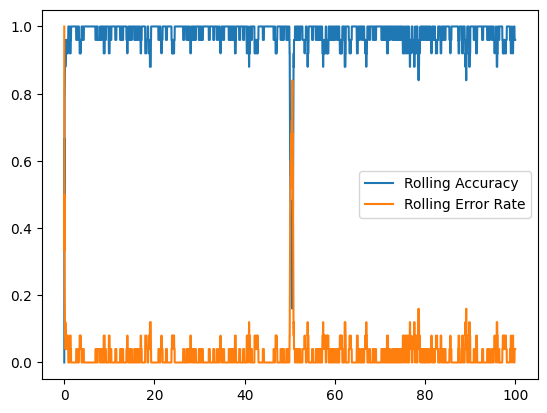

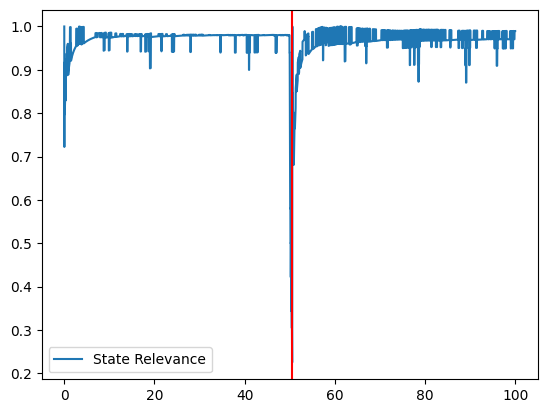

In [14]:
from river.drift import ADWIN

# Set some parameters for out system
window_size = 25
update_period = 1

# Setup a repository to keep track of states
# We need to tell the repository how to create new classifiers and representations when we add a new state.
classifier_constructor = naive_bayes.GaussianNB
representation_constructor = lambda state_id: ErrorRateRepresentation(window_size=window_size, concept_id=state_id, mode="concept", update_period=update_period)
state_repository = Repository(
    classifier_constructor=classifier_constructor,
    representation_constructor=representation_constructor
)


active_state = state_repository.add_next_state()

# Finally, we need a comparer to calculate the similarity
# between the current state representation and a representation
# of recent data
sim = AbsoluteValueComparer()

recent_representation = ErrorRateRepresentation(window_size=window_size, concept_id=active_state.state_id, update_period=update_period)
preds = []
state_relevance = []
detected_drifts = []
accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

# initialize drift detector
drift_detector = ADWIN()

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    observation = Observation(x=x, y=y, seen_at=t, active_state_id=active_state.state_id)
    p = active_state.predict_one(observation)
    preds.append(p)
    _ = active_state.learn_one(observation)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())

    # Update the representation of recent data
    recent_representation.learn_one(observation)

    # The relevance of the current state represents the similarity between it's
    # representation and recent data.
    curr_state_relevance = get_state_relevance(sim, active_state, recent_representation)

    # update drift detector
    # Some issues with typing, float -> Number
    _ = drift_detector.update(curr_state_relevance) # type: ignore
    in_drift = drift_detector.drift_detected
    if in_drift and curr_state_relevance < drift_detector.estimation:
        detected_drifts.append(T[t])

        # Construct a new current state
        # Reset other statistics associated with the active state
        active_state = state_repository.add_next_state()
        recent_representation = ErrorRateRepresentation(window_size=window_size, concept_id=active_state.state_id, update_period=update_period)
        
    # Saving results for plotting
    state_relevance.append(curr_state_relevance)

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.plot(T, error_rate, label="Rolling Error Rate")
plt.legend()
plt.show()
plt.plot(T, state_relevance, label="State Relevance")
for t in detected_drifts:
    plt.axvline(t, c="red")
plt.legend()

We observe that we now are able to learn the new concept much more accurately.
This is because the new active state has forgotten the irrelevant experience from the previous concept.

### Adative Learning Class

The adaptive learning class in this library encapsulates this basic process, with the aim of maintaining a set of states each trained on a different concept, with an active state selected to handle each observation.

The next cell block shows how the system shown above can be implemented using the adaptive learning class

0 0.9682780454698784 0.05732487775614614
-1 0.0 0.0
Overall average accuracy was: 0.9722441416977828


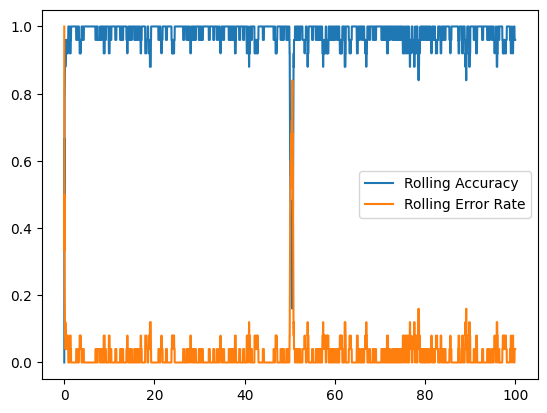

In [15]:
from streamselect.adaptive_learning import BaseAdaptiveLearner


# Set some parameters for out system
window_size = 25
update_period = 1

classifier = BaseAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    # Lower indicates that we want to detect *falls* in relevance.
    # This avoids detecting increases in relevance, e.g., as
    # the state learns to better represent a concept.
    drift_detection_mode="lower"
)

accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    p = classifier.predict_one(x, timestep=t)
    # We should be making the exact same predictions as the previous code!
    assert p == preds[t]
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.plot(T, error_rate, label="Rolling Error Rate")
plt.legend()
plt.show()

In this example, we are only interested in creating new states to handle concept drift. In this case, we can use a streamlined adaptive learning system called a *Discrete Segment Adaptive Learning System*. In this case, we are treating each segment of the data stream, separated by concept drift, using a discrete state.

0 0.9682780454698784 0.05732487775614614
Overall average accuracy was: 0.9722441416977828


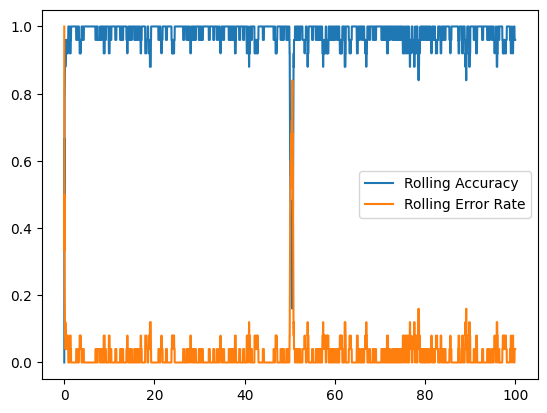

In [16]:
from streamselect.adaptive_learning import DiscreteSegmentAL


# Set some parameters for out system
window_size = 25
update_period = 1

classifier = DiscreteSegmentAL(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower"
)

accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

for t, (x, y) in enumerate(stream.iter_array(X.reshape(-1, 1), Y)):
    p = classifier.predict_one(x, timestep=t)
    # We should be making the exact same predictions as the previous code!
    assert p == preds[t]
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())
    assert len(classifier.repository.states) == 1

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.plot(T, accuracy, label="Rolling Accuracy")
plt.plot(T, error_rate, label="Rolling Error Rate")
plt.legend()
plt.show()

In this case, the DiscreteSegmentAL class has identical functionality, but only maintains the current state in memory. This is more efficient if we are only constructing new states, and do not reuse previous states.



Is constructing a new state the most effective form of adaptation?

It can be, if we have no previous experience relevant to the new concept. However, we often do have experience which is somewhat relevant. For example, a previous concept may have had similar fundamental patterns, or a concept may simply have reoccured. In the first case, research on transfer learning is investigating how we may transfer relevant patterns from similar experience in the past. 

In this library, we investigate fully recurring concepts. These are common in the real world, for example, recurring weather patterns or consumer behaviour. 
In these cases, we need to search our repository for a relevant state to reuse, rather than simply building a new one. We investigate this topic in other examples.

In the next two code blocks we give a brief example of reusing states

We first show that the DiscreteSegmentAL class *does not* reuse states. We repeat the initial data set twice, so we observe four data stream segments with changing concept. However, since we repeated the data set, the second repeat shares the same concepts with the first repeat. 

For example, in the original data set we had the sequence of concept [0, 1]. In this repeated dataset we have the sequence of concepts [0, 1, 0, 1]. 

In the next code block, we plot the accuracy of the model as a scatter plot with markers colored by the active state used by the model. We observe that each of the four segments gets a new state to represent it.

0 0.9682780454698784 0.05732487775614614
1 0.9624426377901267 0.06761149813694584
2 0.9707709054032867 0.044459422686008276
Overall average accuracy was: 0.9713720708488914


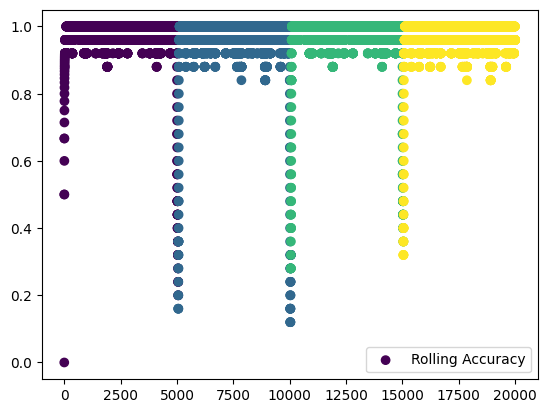

In [17]:
from streamselect.adaptive_learning import DiscreteSegmentAL
from itertools import chain


# Set some parameters for out system
window_size = 25
update_period = 1

classifier = DiscreteSegmentAL(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower"
)

accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

timesteps = []
active_state_id = []
for t, (x, y) in enumerate(chain(stream.iter_array(X.reshape(-1, 1), Y), stream.iter_array(X.reshape(-1, 1), Y))):
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())
    assert len(classifier.repository.states) == 1
    timesteps.append(t)
    active_state_id.append(classifier.active_state_id)

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.scatter(timesteps, accuracy, c = active_state_id, label="Rolling Accuracy")
plt.legend()
plt.show()

The above approach does successfully handle concept drift, however loses some information. If we have recurring concepts, the experience learned from previous recurrences can help us more accurately predict future recurrences. For example, in this case we could reuse the experience we learned from the first segment on the third segment, and experience learned from the second segment on the fourth.

A simple way to transfer this experience is to *reuse* the state!

In the next code block, we show that the BaseAdaptiveLearner has the ability to recognize when incoming data is similar to a concept seen in the past. Not only can we detect concept drift, but we can retrieve the correct state from the repository to reuse.

We observe that only two states are used as we expect! (We observe this from the color of the scatter plot.)

0 0.9682780454698784 0.05732487775614614
-1 0.0 0.0
0 0.9682780454698784 0.05732487775614614
1 0.9624426377901267 0.06761149813694584
-1 0.0 0.0
0 0.9704483324940996 0.04948191600445565
1 0.9624426377901267 0.06761149813694584
-1 0.0 0.0
Overall average accuracy was: 0.9730720708488915


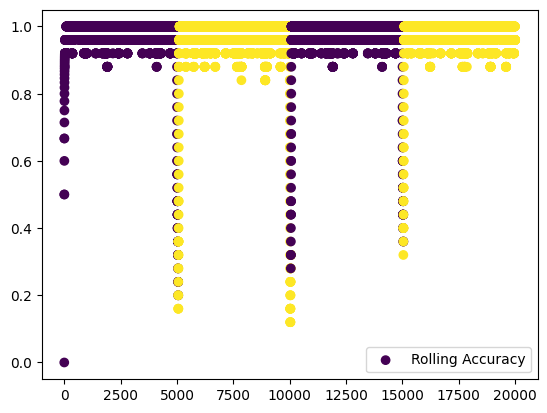

In [18]:
from itertools import chain


# Set some parameters for out system
window_size = 25
update_period = 1

classifier = BaseAdaptiveLearner(
    classifier_constructor=naive_bayes.GaussianNB,
    representation_constructor=ErrorRateRepresentation,
    representation_comparer=AbsoluteValueComparer(),
    drift_detector_constructor=ADWIN,
    representation_window_size=window_size,
    representation_update_period=update_period,
    drift_detection_mode="lower"
)

accuracy = []
error_rate = []
acc_metric = Rolling(Accuracy(), window_size=window_size)

timesteps = []
active_state_id = []
for t, (x, y) in enumerate(chain(stream.iter_array(X.reshape(-1, 1), Y), stream.iter_array(X.reshape(-1, 1), Y))):
    p = classifier.predict_one(x, timestep=t)
    classifier.learn_one(x, y, timestep=t)
    acc_metric.update(y, p)
    accuracy.append(acc_metric.get())
    error_rate.append(1 - acc_metric.get())
    timesteps.append(t)
    active_state_id.append(classifier.active_state_id)

print(f"Overall average accuracy was: {np.mean(accuracy)}")
plt.scatter(timesteps, accuracy, c = active_state_id, label="Rolling Accuracy")
plt.legend()
plt.show()

In other examples we explore the concept re-identification and adaptation process further.